In [1]:
%load_ext autoreload
%autoreload 2

import torch
from utils import segment_and_visualize
from models.unetv2.unetv2 import Unet
from dataset import SpaceNetDataset
import torchvision.datasets as dset
import torchvision.transforms as T
from data_transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import os
from skimage import io
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# load model from checkpoint
#cp_path = '/home/lxhfirenking/work/cs231n/project/bunny/buildings/checkpoints/unet_checkpoint_epoch2.pth.tar'
#cp_path = '/home/lxhfirenking/work/cs231n/project/bunny/buildings/checkpoints/unet_checkpoint_epoch4_2018-05-16-05-01-16.pth.tar'
#cp_path = '/home/lxhfirenking/work/cs231n/project/bunny/buildings/checkpoints/unet_checkpoint_epoch6_2018-05-16-05-23-55.pth.tar'
#cp_path = '/home/lxhfirenking/work/cs231n/project/bunny/buildings/checkpoints_old/unet_checkpoint_epoch9_2018-05-16-06-02-57.pth.tar'
#cp_path = '/home/lxhfirenking/work/cs231n/project/bunny/buildings/checkpoints/unet_checkpoint_epoch9_2018-05-26-21-52-44.pth.tar'
#cp_path = '/home/lxhfirenking/work/cs231n/project/bunny/buildings/checkpoints/unet_checkpoint_epoch19_2018-05-27-02-17-46.pth.tar'
#cp_path = '/home/lxhfirenking/work/cs231n/project/bunny/buildings/checkpoints/unetv2_equal_weights/unet_checkpoint_epoch19_2018-06-01-05-52-02.pth.tar'
cp_path = '/home/lxhfirenking/work/cs231n/project/bunny/buildings/checkpoints/unetv2_interior_weights/unet_checkpoint_epoch19_2018-06-03-04-00-35.pth.tar'
checkpoint = torch.load(cp_path)
model = Unet(feature_scale=1, n_classes=3, is_deconv=True, in_channels=3, is_batchnorm=True)
model.load_state_dict(checkpoint['state_dict'])

In [40]:
# randomly choose an image from validation set
root_path = '/home/lxhfirenking/work/cs231n/project/data/Vegas_8bit_256_val/'

train_batch_size = 1
val_batch_size = 1
test_batch_size = 1
num_workers = 1 # num_workers: how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process

dset_val = SpaceNetDataset(root_path, ['trainval', 'test'], transform=T.Compose([ToTensor()]))
loader_val = DataLoader(dset_val, batch_size=train_batch_size, shuffle=True, num_workers=num_workers) # shuffle True to reshuffle at every epoch

for i, data in enumerate(loader_val):
    if i == 1:
        break
    imagex = data['image'].type(torch.float32)
    namex =  '/home/lxhfirenking/work/cs231n/project/data/Vegas_8bit_256_val/annotations/' + data['image_name'][0]
    print(namex)

/home/lxhfirenking/work/cs231n/project/data/Vegas_8bit_256/annotations/RGB-PanSharpen__-115.2169488_36.1447838998.jpg


In [11]:
# loading image from path
#image_path = '/home/lxhfirenking/work/cs231n/project/data/Vegas_8bit_256_val/annotations/RGB-PanSharpen__-115.3064538_36.1756826998.jpg'
#image_path = '/home/lxhfirenking/work/cs231n/project/data/Vegas_8bit_256_val/annotations/RGB-PanSharpen__-115.3064538_36.1640888998.jpg'
#image_path = '/home/lxhfirenking/work/cs231n/project/data/Vegas_8bit_256/annotations/RGB-PanSharpen__-115.2215226_36.2178026999.jpg'
#image_path = '/home/lxhfirenking/work/cs231n/project/data/Vegas_8bit_256/annotations/RGB-PanSharpen__-115.2401364_36.2118464999.jpg'
#image_path= '/home/lxhfirenking/work/cs231n/project/data/Vegas_8bit_256/annotations/RGB-PanSharpen__-115.1548326_36.1904138999.jpg'

# bad examples
#image_path = '/home/lxhfirenking/work/cs231n/project/data/Vegas_8bit_256_val/annotations/RGB-PanSharpen__-115.2390726_36.1939238999.jpg'
# ^ highest false negative count. F1 0.6, tp 12, fp 1, fn 15

#image_path = '/home/lxhfirenking/work/cs231n/project/data/Vegas_8bit_256_val/annotations/RGB-PanSharpen__-115.1678088_36.1627064998.jpg'
# ^ F1 score of 0, tp 0, fp 2, fn 8 - we did not recognize the large building as one, but on pixel level, it's quite good

image_path = '/home/lxhfirenking/work/cs231n/project/data/Vegas_8bit_256_val/annotations/RGB-PanSharpen__-115.2204588_36.1921688999.jpg'
# model did very well but since the buildings are quite small, the polygons were filtered out due to their small area
# F1 score of 0, tp 0, fp 0, fn 5

# image_path = '/home/lxhfirenking/work/cs231n/project/data/Vegas_8bit_256_val/annotations/RGB-PanSharpen__-115.2355626_36.1693538998.jpg'


original_image = io.imread(image_path)
image = original_image.transpose((2, 0, 1))
image = torch.from_numpy(np.expand_dims(image,0)).type(torch.float32)
#print(image)

image_path:  /home/lxhfirenking/work/cs231n/project/data/Vegas_8bit_256_val/annotations/RGB-PanSharpen__-115.2204588_36.1921688999.jpg


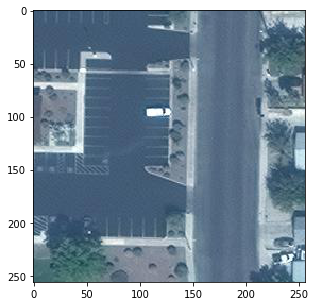

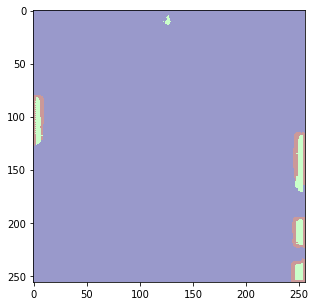

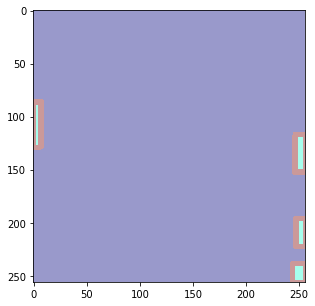

In [12]:
original, transformed, name = original_image, image, image_path # uncomment this if you are using the image path block
#original, transformed, name = io.imread(namex), imagex, namex # uncomment this if you are using the dataloader block

imsavepath = '/home/lxhfirenking/work/cs231n/project/data/results/' + name.split('/')[-1].split('.jpg')[0] + '_out.png'

model.eval()  # set model to evaluation mode
with torch.no_grad():
    scores = model(transformed)
    _, prediction = scores.max(1)
print ("image_path: ", name)
fig = plt.figure(figsize=(5,5))
plt.imshow(original, interpolation='none')
fig = plt.figure(figsize=(5,5))
plt.imshow(prediction.reshape((256,256)), cmap='jet', interpolation='none', alpha=0.4)
#plt.imsave(imsavepath, prediction.reshape((256,256)), format='png' )
fig = plt.figure(figsize=(5,5))
plt.imshow(io.imread(name.replace(".jpg", 'segcls.png')), cmap='jet', interpolation='none', alpha=0.4)